In [1]:
import torch
import wandb
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

/Users/cdesforges/PycharmProjects/MINST_Model/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
if torch.backends.mps.is_available():
    print("MPS backend is available!")
else:
    print("MPS backend is not available.")

MPS backend is available!


In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # Define layers as a sequential block
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.layers(x)       # Pass through the sequential layers
        return x

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        return self.layers(x)
        

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

In [6]:
batch_size = 32          # how many images to analyze at a time (smaller better for generalization, higher for faster)
epochs = 50             # number of runs (int)
learning_rate = 0.001   # size of gradient descent steps (usually le-3 to le-4)
hidden_size = 128       # hidden layer size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)               # object that loads training set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)                # object that loads test set

# SET DEVICE
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

#model = MLP(input_size=28*28, hidden_size=hidden_size, output_size=10)                      # MLP model
model = CNN().to(device)                                                                               # CNN model

criterion = nn.CrossEntropyLoss()                                                           # this is our loss criterion
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-4)      # our backprop algorithm
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

Using device: mps


In [7]:
def train():
    model.train()
    total_loss = 0
    correct = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)           # first param = dimensionality of input class, 2nd indicates index of max val in tensor
        correct += (predicted==labels).sum().item()
        
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / len(train_loader.dataset)

    
    return avg_loss, accuracy

def test():
    model.eval()
    
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted==labels).sum().item()
            
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / len(test_loader.dataset)
            
    return avg_loss, accuracy        

In [28]:
wandb.init(project="MNIST_Model_CNN",
           name="V_2_DO_0.5",
           config={
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "epochs": epochs
})

In [29]:
best_loss = float('inf')
patience = 10
no_improvement = 0


try:
    for epoch in range(epochs):
        training_loss, training_acc = train()
        test_loss, test_acc = test()
        
        print(f"epoch {epoch+1} of {epochs}: training_loss = {training_loss:.4f}, training_accuracy = {training_acc:.4f}, test_loss = {test_loss:.4f}, test_accuracy = {test_acc:.4f}, lr_size = {optimizer.param_groups[0]['lr']:.10f}")
        
        if test_loss < best_loss:
            best_loss = test_loss
            no_improvement = 0
        else:
            no_improvement += 1             # check to see if our loss is still going down
            
        if no_improvement > patience:
            break                           # if not get out!
        
        wandb.log({
            "epoch": epoch,
            "lr": optimizer.param_groups[0]['lr'],
            "train_loss": training_loss,
            "train_accuracy": training_acc,
            "test_loss": test_loss,
            "test_accuracy": test_acc
        })
        
        scheduler.step(test_loss)
finally:
    wandb.finish()

epoch 1 of 50: training_loss = 0.1991, training_accuracy = 0.9382, test_loss = 0.0534, test_accuracy = 0.9821, lr_size = 0.0010000000
epoch 2 of 50: training_loss = 0.0939, training_accuracy = 0.9716, test_loss = 0.0408, test_accuracy = 0.9867, lr_size = 0.0010000000
epoch 3 of 50: training_loss = 0.0788, training_accuracy = 0.9761, test_loss = 0.0387, test_accuracy = 0.9883, lr_size = 0.0010000000
epoch 4 of 50: training_loss = 0.0666, training_accuracy = 0.9795, test_loss = 0.0322, test_accuracy = 0.9903, lr_size = 0.0010000000
epoch 5 of 50: training_loss = 0.0620, training_accuracy = 0.9810, test_loss = 0.0290, test_accuracy = 0.9905, lr_size = 0.0010000000
epoch 6 of 50: training_loss = 0.0548, training_accuracy = 0.9832, test_loss = 0.0353, test_accuracy = 0.9899, lr_size = 0.0010000000
epoch 7 of 50: training_loss = 0.0553, training_accuracy = 0.9823, test_loss = 0.0375, test_accuracy = 0.9884, lr_size = 0.0010000000
epoch 8 of 50: training_loss = 0.0502, training_accuracy = 0.9

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
lr,█████████▂▂▂▂▂▂▂▁▁▁▁▁▁
test_accuracy,▁▄▅▆▆▆▅▆▆▇█▇▇██▇▇█████
test_loss,█▅▄▃▂▄▄▃▄▁▁▁▁▁▂▂▂▁▁▁▁▁
train_accuracy,▁▅▅▆▆▆▆▆▆▇████████████
train_loss,█▄▄▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,21
lr,1e-05
test_accuracy,0.9926
test_loss,0.02561
train_accuracy,0.99768


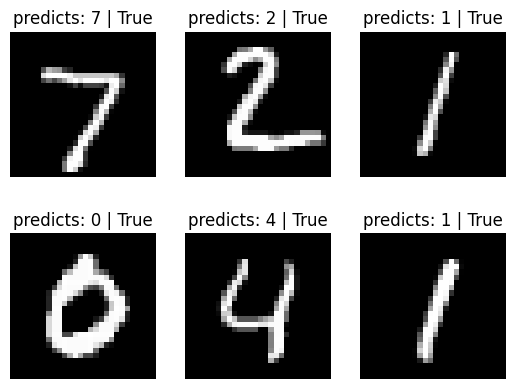

In [29]:
import matplotlib.pyplot as plt

state_dict = torch.load("CNN_DO_WD_99_25.pth", weights_only=True)
model.load_state_dict(state_dict)

examples = iter(test_loader)
example_data, example_labels = next(examples)

example_labels = example_labels.to(device)
example_data = example_data.to(device)

# Run the model
with torch.no_grad():
    outputs = model(example_data)
    _, pred = torch.max(outputs, 1)

# Move data back to CPU for visualization
example_data = example_data.cpu()
example_labels = example_labels.cpu()
pred = pred.cpu()

# Plot the images
fig = plt.figure()

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(example_data[i][0].numpy(), cmap="gray")  # Convert to numpy and set grayscale colormap
    plt.title(f"predicts: {pred[i].item()} | {example_labels[i].item() == pred[i].item()}")
    plt.axis("off")

plt.show()

In [31]:
#torch.save(model.state_dict(), 'CNN_DO_WD_99_25.pth')

In [1]:
!which python

/Users/cdesforges/PycharmProjects/MINST_Model/.venv/bin/python
